# PORTFOLIO OPTIMO (MARKOWITZ)


In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")

In [2]:
import time
import datetime as dt

start = dt.date.today() - dt.timedelta(days = 365*2)


In [3]:

#tickers = ['AAPL','BAC','CSCO','DIS','EDN','F','GGAL','HPE','SPY']
#tickers = ['EDN','GGAL','PAMP.BA','GRIM.BA']
#tickers = ['AAPL','BAC','CSCO','DIS']
tickers = ['AAPL','MSFT','SPY','GLD']
#tickers = ['X' , 'KO' , 'GGAL' , 'GLD' , 'BABA']

start = '2017-01-03'
end = '2020-01-03'
data = yf.download(tickers,start , end)['Adj Close']
#data = yf.download(tickers,start)
#data = data['Adj Close'].dropna()



[*********************100%***********************]  4 of 4 completed


In [4]:
data

,AAPL,GLD,MSFT,SPY
Date,,,,
2017-01-03,27.059311,110.470001,57.254704,201.337387
2017-01-04,27.029022,110.860001,56.998524,202.535172
2017-01-05,27.166475,112.580002,56.998524,202.374298
2017-01-06,27.469332,111.750000,57.492569,203.098328
2017-01-09,27.720938,112.669998,57.309593,202.427902
...,...,...,...,...
2019-12-26,70.702934,142.380005,153.210770,305.549652
2019-12-27,70.676117,142.330002,153.490814,305.473877
2019-12-30,71.095558,142.630005,152.167938,303.789764


<AxesSubplot:xlabel='Date'>

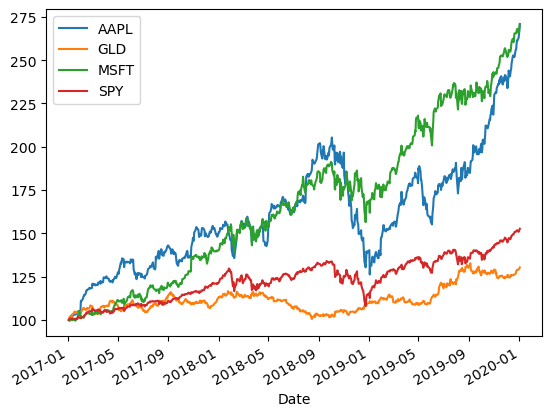

In [5]:
(data / data.iloc[0] * 100).plot()

In [6]:
log_returns = np.log(data/data.shift()).dropna()

In [7]:
log_returns

,AAPL,GLD,MSFT,SPY
Date,,,,
2017-01-04,-0.001120,0.003524,-0.004484,0.005932
2017-01-05,0.005073,0.015396,0.000000,-0.000795
2017-01-06,0.011086,-0.007400,0.008630,0.003571
2017-01-09,0.009118,0.008199,-0.003188,-0.003306
2017-01-10,0.001008,0.004251,-0.000319,0.000000
...,...,...,...,...
2019-12-26,0.019646,0.007827,0.008163,0.005309
2019-12-27,-0.000379,-0.000351,0.001826,-0.000248
2019-12-30,0.005917,0.002106,-0.008656,-0.005528


# Elementos básicos

array([[<AxesSubplot:title={'center':'AAPL'}>,
        <AxesSubplot:title={'center':'GLD'}>],
       [<AxesSubplot:title={'center':'MSFT'}>,
        <AxesSubplot:title={'center':'SPY'}>]], dtype=object)

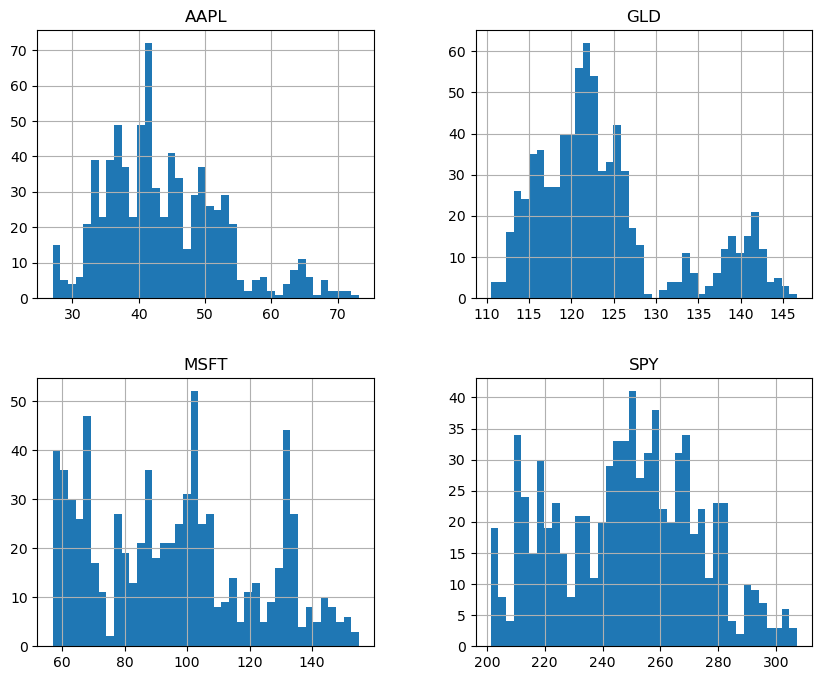

In [8]:
data.hist(bins=40,figsize=(10,8))

array([[<AxesSubplot:title={'center':'AAPL'}>,
        <AxesSubplot:title={'center':'GLD'}>],
       [<AxesSubplot:title={'center':'MSFT'}>,
        <AxesSubplot:title={'center':'SPY'}>]], dtype=object)

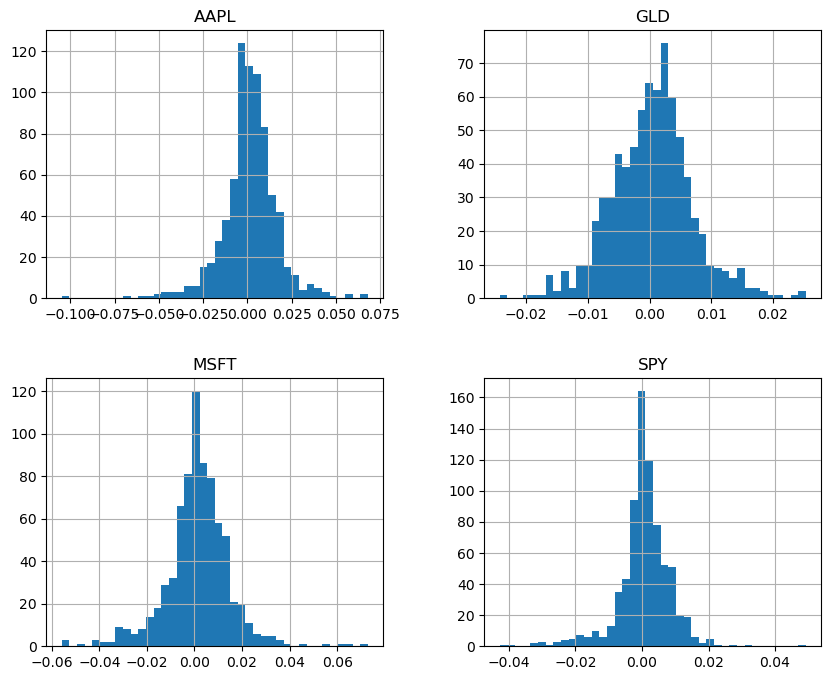

In [9]:
log_returns.hist(bins=40, figsize=(10,8))

### matriz de covarianza anualizada


In [10]:
log_returns.cov()*252

,AAPL,GLD,MSFT,SPY
AAPL,0.061218,-0.003261,0.033642,0.022578
GLD,-0.003261,0.010948,-0.001957,-0.001973
MSFT,0.033642,-0.001957,0.046899,0.022676
SPY,0.022578,-0.001973,0.022676,0.016512


### retornos medios anuales

In [11]:
log_returns.mean()*252

AAPL    0.332825
GLD     0.088475
MSFT    0.333054
SPY     0.141404
dtype: float64

## Modelo teórico basico

In [12]:
noa = len(tickers)
weights = np.random.random(noa)
weights /= np.sum(weights)
weights

array([0.24451181, 0.17662186, 0.32642919, 0.25243714])

In [13]:
weights.sum()

1.0

### Retorno esperado del portfolio

In [14]:
np.sum(log_returns.mean()*weights) *252

0.2414204008005306

### Volatilidad del portfolio

In [15]:
# b = np.dot(log_returns.cov()*252,weights)


In [16]:
# a = np.dot(weights.T, b)


In [17]:
var_portfolio = np.dot(weights.T, np.dot(log_returns.cov()*252,weights))
var_portfolio

0.021262505528343287

In [18]:
std_portfolio=var_portfolio**0.5
std_portfolio

0.14581668467066206

In [19]:
def port_ret(weights):
    return np.sum(log_returns.mean() * weights) * 252

def port_vol(weights):
    return np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 252, weights)))

In [20]:
%%time
prets = []
pvols = []
for p in range (1000):
    weights = np.random.random(noa)  
    weights /= np.sum(weights)  
    prets.append(port_ret(weights))
    pvols.append(port_vol(weights))
prets = np.array(prets)
pvols = np.array(pvols)

Wall time: 790 ms


Text(0, 0.5, 'retorno esperado')

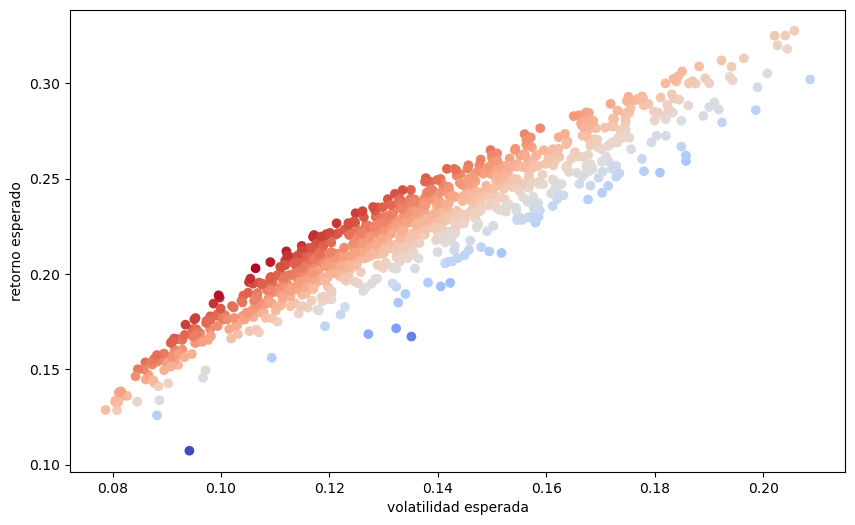

In [21]:
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c = prets / pvols , cmap='coolwarm')
plt.xlabel('volatilidad esperada')
plt.ylabel('retorno esperado')


# Optimización del portfolio

In [22]:
import scipy.optimize as sco

In [23]:
# función a minimizar
def min_func_sharpe(weights):  
    return -port_ret(weights) / port_vol(weights)  

In [24]:
# restricción de igualdad
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})  

In [25]:
# limite de los parámetros
bnds = tuple((0.05, 1) for x in range(noa))  

In [26]:
# vector de pondereaciones iguales
eweights = np.array(noa * [1. / noa,])  


In [27]:
min_func_sharpe(eweights)

-1.695893425318924

In [28]:
eweights

array([0.25, 0.25, 0.25, 0.25])

## Resolviendo mediente derivación matematica el problema de minimización


### Cartera de máximo Sharpe Ratio 

In [29]:
%%time
opts = sco.minimize(min_func_sharpe, eweights,
                    method='SLSQP', bounds=bnds,
                    constraints=cons)  

Wall time: 50.5 ms


In [30]:
opts

     fun: -1.8999800507402407
     jac: array([-0.01626348, -0.01652996, -0.01633681,  0.3122174 ])
 message: 'Optimization terminated successfully'
    nfev: 37
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.153457  , 0.52880081, 0.26774219, 0.05      ])

In [31]:
# ponderación del portfolio óptimo de max sharpe
opts['x'].round(3) 

array([0.153, 0.529, 0.268, 0.05 ])

In [32]:
# retorno del portfolio optimo de max sharpe
port_ret(opts['x']).round(3) 

0.194

In [33]:
# volatilidad del portfolio optimo de max sharpe
port_vol(opts['x']).round(3)  

0.102

In [34]:
# Ratio de sharpe máximo
port_ret(opts['x']) / port_vol(opts['x'])

1.8999800507402407

In [35]:
portfolio_maxs = pd.Series(np.dot(log_returns , opts['x']),index=log_returns.index)
portfolio_maxs

Date
2017-01-04    0.000788
2017-01-05    0.008880
2017-01-06    0.000278
2017-01-09    0.004716
2017-01-10    0.002317
                ...   
2019-12-26    0.009605
2019-12-27    0.000233
2019-12-30   -0.000573
2019-12-31    0.002425
2020-01-02    0.012711
Length: 754, dtype: float64

### Cartera de minima varianza

In [36]:
optv = sco.minimize(port_vol, eweights,
                    method='SLSQP', bounds=bnds,
                    constraints=cons)

In [37]:
optv.x.round(3)

array([0.05, 0.61, 0.05, 0.29])

In [38]:
pond_mv=optv['x']
cartera_mv = dict(zip(tickers,pond_mv))
ret_mv = port_ret(optv['x'])
vol_mv = port_vol(optv['x'])
sharpe_mv = ret_mv / vol_mv

In [39]:
print('Cartera de Mínima Varianza:')
print('-'*len('Cartera de Mínima Varianza:'))

for k,v in cartera_mv.items():
    print(k,v.round(3))

print('Retorno: ',ret_mv.round(3))
print('Volatilidad: ',vol_mv.round(3))
print('Ratio de Sharpe: ',sharpe_mv.round(3))
    

Cartera de Mínima Varianza:
---------------------------
AAPL 0.05
MSFT 0.61
SPY 0.05
GLD 0.29
Retorno:  0.128
Volatilidad:  0.079
Ratio de Sharpe:  1.629


In [40]:
portfolio_minv = pd.Series(np.dot(log_returns , optv['x']),index=log_returns.index)

## Resolviendo con mañas y sin matemática

In [41]:
import random


In [42]:
%%time
p_pond= []
p_ret = []
p_vol = []

for p in range (10000):  
    pond = np.random.random(noa)  
    pond /= np.sum(pond)
    p_pond.append(pond)
    p_ret.append(port_ret(pond))
    p_vol.append(port_vol(pond))
    
prets = np.array(p_ret)
pvols = np.array(p_vol)

Wall time: 8.2 s


In [43]:
result = list(zip(p_pond,p_ret,p_vol))

In [44]:
result = pd.DataFrame(result)

In [45]:
result.columns=['ponderaciones','ret_log','volatilidad']

In [46]:
result['sharpe']=result.ret_log / result.volatilidad
result.head(9)

,ponderaciones,ret_log,volatilidad,sharpe
0,"[0.02150585169418852, 0.342027729985393, 0.331...",0.191023,0.111641,1.711048
1,"[0.08265252129326435, 0.23000835517540308, 0.3...",0.206956,0.125817,1.644893
2,"[0.2963384714577867, 0.23744308507592107, 0.24...",0.231943,0.137705,1.684346
3,"[0.292644797927755, 0.2457788175078472, 0.1385...",0.210961,0.128987,1.635519
4,"[0.36835132611121785, 0.31694085653361026, 0.2...",0.249538,0.141400,1.764774
5,"[0.3451213831471855, 0.3875451112933851, 0.134...",0.212771,0.121668,1.748781
6,"[0.24633688774337362, 0.23064627200259302, 0.2...",0.226338,0.134608,1.681460
7,"[0.29285413646674363, 0.266935902312775, 0.177...",0.217291,0.129446,1.678624
8,"[0.4052710684647254, 0.4011900334918732, 0.164...",0.229181,0.130233,1.759773


In [47]:
result.volatilidad.min()

0.07676475161891275

In [48]:
result.volatilidad.idxmin()

1567

In [49]:
result.sharpe.max()

1.9123279575225054

In [50]:
result.sharpe.idxmax()

2694

In [51]:
result.loc[result.sharpe.idxmax()]


ponderaciones    [0.14682274632444697, 0.5419070727080261, 0.30...
ret_log                                                   0.199353
volatilidad                                               0.104246
sharpe                                                    1.912328
Name: 2694, dtype: object

In [52]:
print('Cartera de Máximo Sharpe:')
print('-'*len('Cartera de Máximo Sharpe:'))

print('Activos en cartera: ', tickers)
print('Proporción activos en cartera: ', result.ponderaciones[result.sharpe.idxmax()].round(4))
print('Retorno: ', result.ret_log[result.sharpe.idxmax()])
print('Volatilidad: ',result.volatilidad[result.sharpe.idxmax()])
print('Ratio de Sharpe: ',result.sharpe[result.sharpe.idxmax()])




Cartera de Máximo Sharpe:
-------------------------
Activos en cartera:  ['AAPL', 'MSFT', 'SPY', 'GLD']
Proporción activos en cartera:  [0.1468 0.5419 0.3054 0.0059]
Retorno:  0.19935258429347508
Volatilidad:  0.10424602302616756
Ratio de Sharpe:  1.9123279575225054


In [53]:
op_vol=result.loc[result.sharpe.idxmax(),'volatilidad']
op_ret=result.loc[result.sharpe.idxmax(),'ret_log']

Text(0.10424602302616756, 0.19935258429347508, 'Optimo')

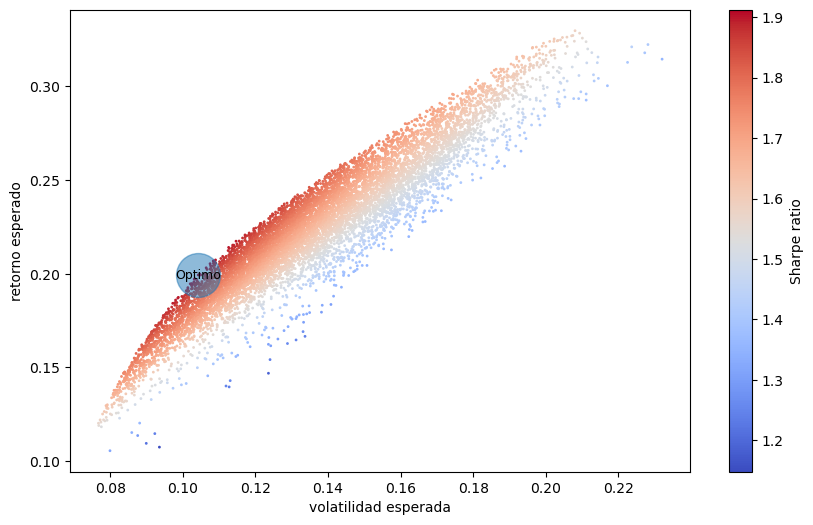

In [54]:
plt.figure(figsize=(10, 6))
plt.scatter(result.volatilidad, result.ret_log, c=result.sharpe , s=1, cmap='coolwarm')
plt.xlabel('volatilidad esperada')
plt.ylabel('retorno esperado')
plt.colorbar(label='Sharpe ratio')

plt.scatter(op_vol, op_ret, c='tab:blue', alpha=0.5, s=1000) 
plt.text(op_vol, op_ret, 'Optimo', fontsize=9, c='k', ha='center', va='center') 
